In [1]:
import numpy as np
import xarray as xr

from tqdm import tqdm

from sklearn import preprocessing, model_selection, ensemble, svm, metrics

import matplotlib.pyplot as plt

In [7]:
DATASETS = {
  'dosenbach2007': xr.open_dataset('data/julia2018_resting/connectivity_dosenbach2007.nc'),
  'difumo_64_2': xr.open_dataset('data/julia2018_resting/connectivity_difumo_64_2.nc'),
  'difumo_128_2': xr.open_dataset('data/julia2018_resting/connectivity_difumo_128_2.nc'),  
}

In [8]:
n_splits = 100

scores = {}

kinds = ['covariance', 'correlation', 'partial_correlation', 'tangent', 'precision']


for ds_name, dataset in DATASETS.items():

    valid_beh_subjects_mask = ~np.isnan(dataset['inverse_efficiency_score_ms'].values)

    y_encoder = preprocessing.LabelEncoder()
    y = y_encoder.fit_transform(dataset['group'])
    y = y[valid_beh_subjects_mask]


    cv = model_selection.StratifiedShuffleSplit(n_splits=n_splits, test_size=.2)

    for kind in kinds:
        scores[f'{ds_name}_{kind}'] = []
        
        # 1d-vectorize the connectivity matrix
        X = np.array([subj_conn[np.triu_indices_from(subj_conn, k=1)] 
                      for subj_conn in dataset[f'{kind}_connectivity'].values])
        X = X[valid_beh_subjects_mask]

        for train, test in tqdm(cv.split(X, y), desc=f'{ds_name} ({kind})', total=n_splits):
            classifier = ensemble.AdaBoostClassifier().fit(X[train], y[train])
            y_pred = classifier.predict(X[test])
            score = metrics.roc_auc_score(y[test], y_pred)
            # score = metrics.accuracy_score(y[test], y_pred)
            scores[f'{ds_name}_{kind}'].append(score)

difumo_128_2 (precision): 100%|██████████| 100/100 [01:04<00:00,  1.54it/s]


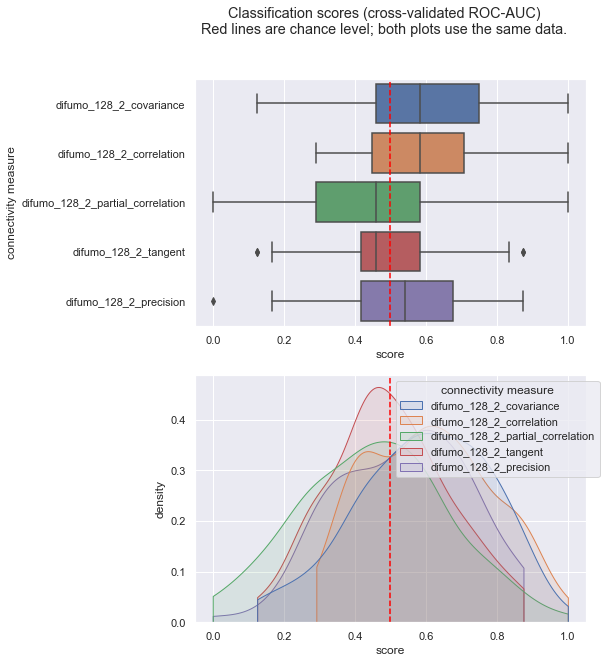

In [9]:
import pandas as pd
import seaborn as sns; sns.set()

measure_names = [f'{ds_name}_{kind}' for kind in kinds for ds_name in DATASETS.keys()]

plotting_data = pd.DataFrame({
  'measure_name': measure_names,
})


scores_df = pd.DataFrame.from_dict(scores).melt(var_name='measure_name', value_name='score')

fig, axes = plt.subplots(2, 1, figsize=(7, 10))

# box/violin plot
sns.boxplot(data=scores_df, y='measure_name', x='score', orient='horizontal', ax=axes[0])
axes[0].set(ylabel='connectivity measure')

# dist plot
g = sns.kdeplot(
  data=scores_df, x='score', hue='measure_name',
  fill=True, clip=(0,1), alpha=.12, cut=0,
  ax=axes[1])

g.set(ylabel='density')
axes[1].get_legend().set_title('connectivity measure')
axes[1].get_legend().set_bbox_to_anchor((1.05, 1))

# plot chance line
axes[0].axvline(.5, color='red', linestyle='--')
axes[1].axvline(.5, color='red', linestyle='--')

plt.suptitle('Classification scores (cross-validated ROC-AUC)'
             '\nRed lines are chance level; both plots use the same data.')

plt.show()